In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as pt
import re
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

#loading input data 
train=pd.read_csv("../input/train.csv")
test=pd.read_csv("../input/test.csv")

combine=pd.concat([train.drop('Survived',1),test])
# Any results you write to the current directory are saved as output.
train.head()

gender_submission.csv
test.csv
train.csv



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**FEATURE ANALYSIS**

Pclass is the Ticket-class: first (1), second (2), and third (3) class tickets were used. This is an ordinal integer feature.

Name is the name of the passenger. The names also contain titles and some persons might share the same surname; indicating family relations. We know that some titles can indicate a certain age group. For instance Master is a boy while Mr is a man. This feature is a character string of variable length but similar format.

Sex is an indicator whether the passenger was female or male. This is a categorical text string feature.

Age is the integer age of the passenger. There are NaN values in this column.

SibSp is another ordinal integer feature describing the number of siblings or spouses travelling with each passenger.

Parch is another ordinal integer features that gives the number of parents or children travelling with each passenger.

Ticket is a character string of variable length that gives the ticket number.

Fare is a float feature showing how much each passenger paid for their rather memorable journey.

Cabin gives the cabin number of each passenger. There are NaN in this column. This is another string feature.

Embarked shows the port of embarkation as a categorical character value.

In [78]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**MISSING VALUES**

In [79]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

test.isnull().sum()

In [80]:
surv=train[train['Survived']==1]
nosurv=train[train['Survived']==0]
#finding the percentage of survival
print ("survived perc %f" %(len(surv)/len(train)*100))
print ("not survived perc %.1f" %(len(nosurv)/len(train)*100))
surv_col="Green"
nosurv_col="Red"

survived perc 38.383838
not survived perc 61.6


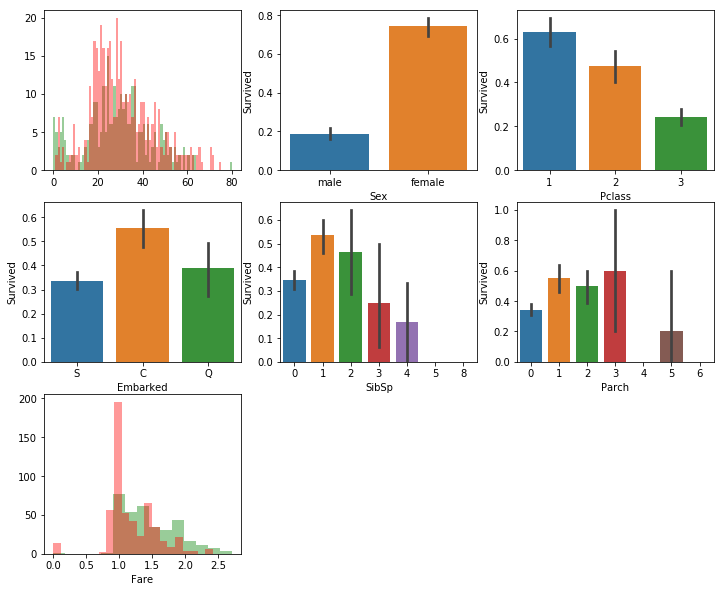

In [81]:
pt.figure(figsize=[12,10])
pt.subplot(331)
sns.distplot(surv['Age'].dropna().values,bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values,bins=range(0, 81, 1), kde=False, color=nosurv_col)
#obs: neither no infants(<1) nor the aged died 
pt.subplot(332)
sns.barplot('Sex','Survived',data=train)
#obs: Mostly female survived
pt.subplot(333)
sns.barplot('Pclass','Survived',data=train)
#obs: higher class people survived mostly
pt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train)
#obs: people who embarked through C has higher survival rate
pt.subplot(335)
sns.barplot('SibSp', 'Survived', data=train)
#obs:people with singe sibling have higher survival rate
pt.subplot(336)
sns.barplot('Parch', 'Survived', data=train)
pt.subplot(337)
sns.distplot(np.log10(surv['Fare'].dropna()+1),kde=False,color=surv_col)
sns.distplot(np.log10(nosurv['Fare'].dropna()+1),kde=False,color=nosurv_col)
#obs: highest fare people have survived and people with 0 fare have died


In [82]:
pd.crosstab(train['Embarked'],train['Survived'])

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


**Understand cabin**

In [83]:
#Cabin is albhanumeric, contains missing values, and we have to see how it is related to survival
print("There are cabins %i/%i in train"%(len(train['Cabin'].dropna()),len(train)))
print("There are cabins %i/%i in test"%(len(test['Cabin'].dropna()),len(test)))
#find unique value count
print("Unique train cabin numbers are %i"%(len(train['Cabin'].dropna().unique())))
print("Unique test cabin numbers are %i"%(len(test['Cabin'].dropna().unique())))

There are cabins 204/891 in train
There are cabins 91/418 in test
Unique train cabin numbers are 147
Unique test cabin numbers are 76


In [84]:
train.loc[:,['Survived','Cabin']].head(10)
#obs: some people have missing cabin/more than one cabin numbers

,Survived,Cabin
0,0,NaN
1,1,C85
2,1,NaN
3,1,C123
4,0,NaN
5,0,NaN
6,0,E46
7,0,NaN
8,1,NaN
9,1,NaN


**TICKET NUMBERS**

In [85]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [86]:
train['Ticket'].isnull().sum()
#obs: everyone had ticket
print ("there are %i unique tickets out of %i tickets"%(train['Ticket'].nunique(),len(train)))
#So a tikcet has been shared with people
grouped=train.groupby('Ticket')
for key,value in grouped:
    if (len(grouped.get_group(key))>1):
        print (value.loc[:,['Survived','Name','Fare']])

there are 681 unique tickets out of 891 tickets
     Survived                                               Name  Fare
257         1                               Cherry, Miss. Gladys  86.5
504         1                              Maioni, Miss. Roberta  86.5
759         1  Rothes, the Countess. of (Lucy Noel Martha Dye...  86.5
     Survived                                    Name   Fare
262         0                       Taussig, Mr. Emil  79.65
558         1  Taussig, Mrs. Emil (Tillie Mandelbaum)  79.65
585         1                     Taussig, Miss. Ruth  79.65
     Survived                            Name  Fare
110         0  Porter, Mr. Walter Chamberlain  52.0
475         0     Clifford, Mr. George Quincy  52.0
     Survived                                             Name     Fare
329         1                     Hippach, Miss. Jean Gertrude  57.9792
523         1  Hippach, Mrs. Louis Albert (Ida Sophia Fischer)  57.9792
     Survived                                    Nam

     Survived                                           Name  Fare
249         0                  Carter, Rev. Ernest Courtenay  26.0
854         0  Carter, Mrs. Ernest Courtenay (Lilian Hughes)  26.0
     Survived                                 Name  Fare
99          0                    Kantor, Mr. Sinai  26.0
316         1  Kantor, Mrs. Sinai (Miriam Sternin)  26.0
     Survived                               Name  Fare
596         1         Leitch, Miss. Jessie Wills  33.0
720         1  Harper, Miss. Annie Jessie "Nina"  33.0
848         0                  Harper, Rev. John  33.0
     Survived                                               Name  Fare
78          1                      Caldwell, Master. Alden Gates  29.0
323         1  Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...  29.0
     Survived                                       Name  Fare
272         1  Mellinger, Mrs. (Elizabeth Anne Maidment)  19.5
446         1          Mellinger, Miss. Madeleine Violet  19.5
     S

     Survived                 Name   Fare
109         1  Moran, Miss. Bertha  24.15
517         0    Ryan, Mr. Patrick  24.15
768         0  Moran, Mr. Daniel J  24.15
     Survived                                               Name  Fare
431         1  Thorneycroft, Mrs. Percival (Florence Kate White)  16.1
639         0                         Thorneycroft, Mr. Percival  16.1
     Survived                                  Name    Fare
16          0                  Rice, Master. Eugene  29.125
171         0                  Rice, Master. Arthur  29.125
278         0                    Rice, Master. Eric  29.125
787         0             Rice, Master. George Hugh  29.125
885         0  Rice, Mrs. William (Margaret Norton)  29.125
     Survived                 Name    Fare
751         1  Moor, Master. Meier  12.475
823         1   Moor, Mrs. (Beila)  12.475
     Survived                           Name     Fare
176         0  Lefebre, Master. Henry Forbes  25.4667
229         0        L

**FINDING RELATION BETWEEN FEATURES**

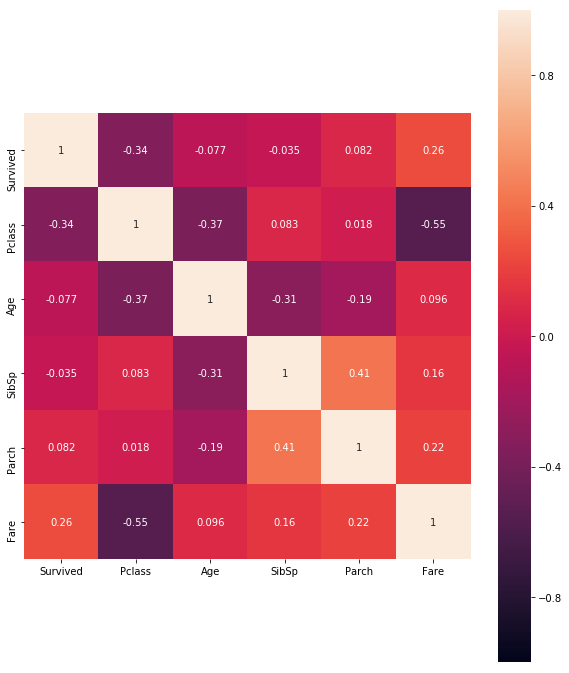

In [87]:
pt.figure(figsize=(10,12))
sns.heatmap(train.drop('PassengerId',axis=1).corr(),vmin=-1,vmax=1,square=True,annot=True)
#obs: fare and survived, Parch an dsurvived



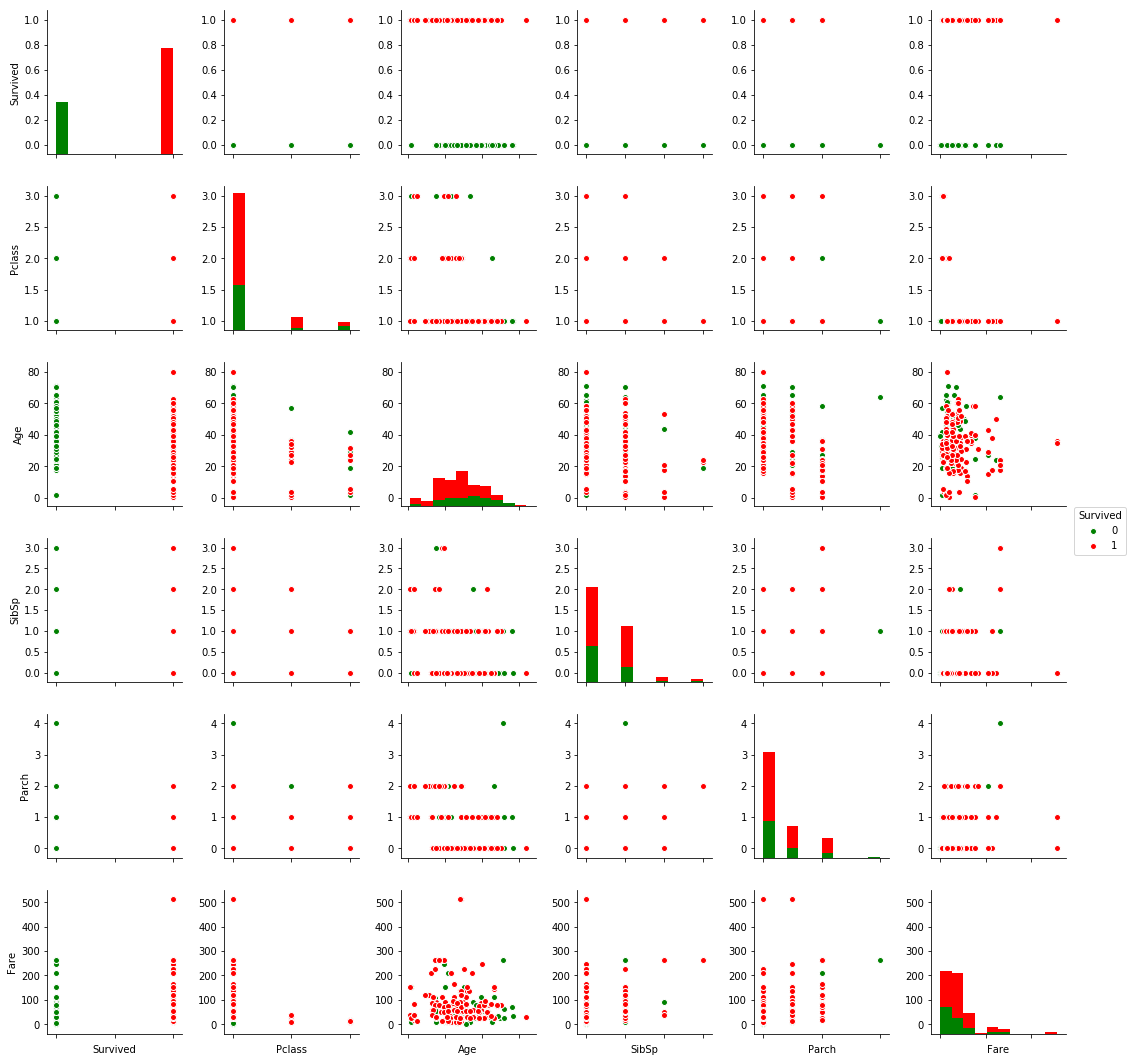

In [88]:
cols=['Survived','Pclass','Age','SibSp','Parch','Fare']
g=sns.pairplot(train.dropna(),hue='Survived',vars=cols,size=2.5,palette=[surv_col,nosurv_col])
g.set(xticklabels=[])

**correlations between the predictor features and how they could affect the target Survived behaviour.**

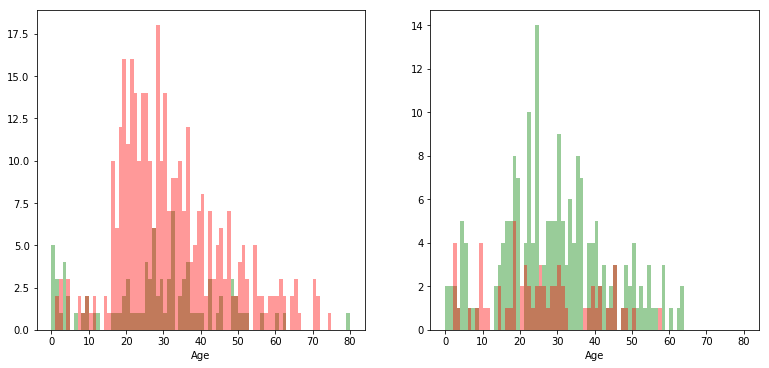

In [89]:
#Gender and survival
Msurv=train[(train['Sex']=="male")&(train['Survived']==1)]
Fsurv=train[(train['Sex']=="female")&(train['Survived']==1)]
Mnosurv=train[(train['Sex']=="male")&(train['Survived']==0)]
Fnosurv=train[(train['Sex']=="female")&(train['Survived']==0)]
pt.figure(figsize=(20,20))
pt.subplot(331)
sns.distplot(Msurv['Age'].dropna(),bins=range(0, 81, 1),kde=False,color=surv_col)
sns.distplot(Mnosurv['Age'].dropna(),bins=range(0, 81, 1),kde=False,color=nosurv_col)

pt.subplot(332)
sns.distplot(Fsurv['Age'].dropna(),bins=range(0, 81, 1),kde=False,color=surv_col)
sns.distplot(Fnosurv['Age'].dropna(),bins=range(0, 81, 1),kde=False,color=nosurv_col)
#obs:
#boys have higher survival rate
#males between 15 - 75 less survival rate comparing to female

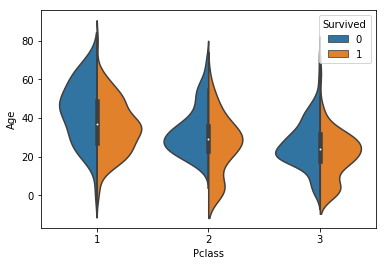

In [90]:
sns.violinplot(x=train['Pclass'],y=train['Age'],hue=train['Survived'],split=True)
#obs:

#1.Pclass 1: has older people, not survived
#2.Pclass 3: has very less older people,Children rate is high
#3.Pclass 2: children survial rate is high

In [91]:
mosaic(train,["Survived","Sex","Pclass"])

NameError: name 'mosaic' is not defined

In [ ]:
sns.factorplot(x="Pclass",y='Survived',hue='Sex',col='Embarked',data=train)
#obs:
#Male has lower survival,Female has lower survival in case of 3 class


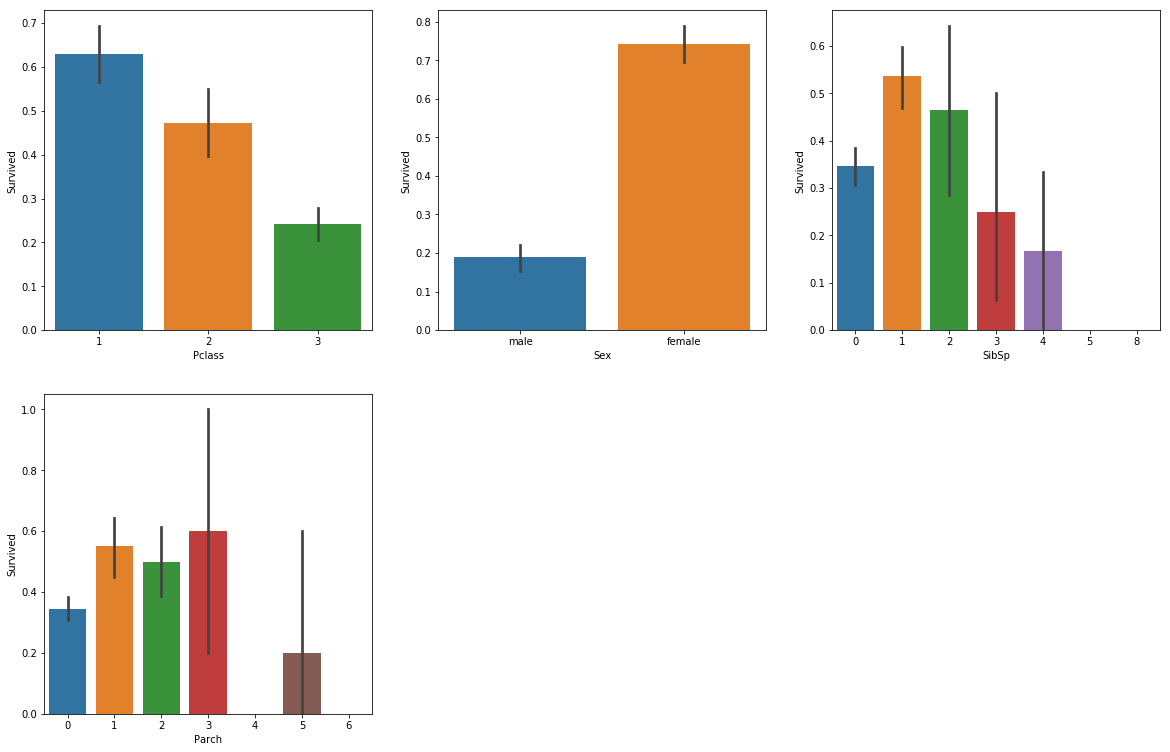

In [92]:
pt.figure(figsize=(20,20))
pt.subplot(331)
sns.barplot("Pclass","Survived",data=train)
pt.subplot(332)
sns.barplot("Sex","Survived",data=train)
pt.subplot(333)
sns.barplot("SibSp","Survived",data=train)
pt.subplot(334)
sns.barplot("Parch","Survived",data=train)

In [93]:
train[["Parch","Survived"]].groupby("Parch").mean().sort_values(by='Survived',ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


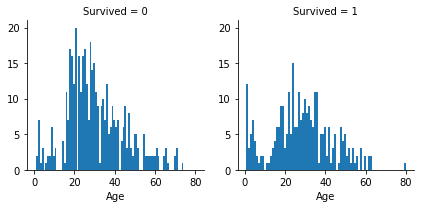

In [94]:
struct=sns.FacetGrid(data=train,col="Survived")
struct.map(pt.hist,"Age",bins=80)

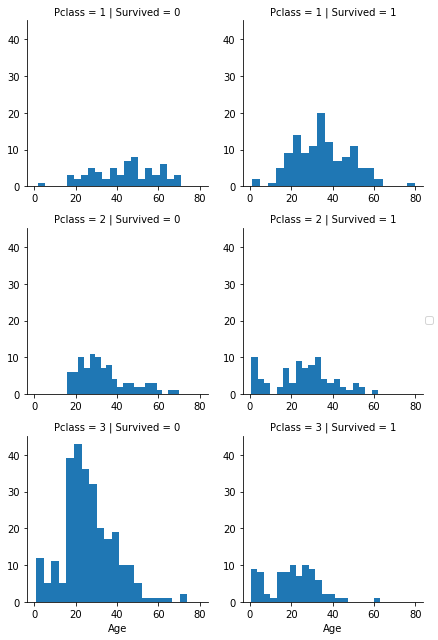

In [95]:
struct=sns.FacetGrid(data=train,col="Survived",row="Pclass")
struct.map(pt.hist,"Age",bins=20)
struct.add_legend()

**WRANGLE DATA**

In [96]:
#REMOVE USELESS COLUMNs
train=train.drop(['Ticket','Cabin'],axis=1)
test=test.drop(['Ticket','Cabin'],axis=1)


CREATING NEW FEATURES

In [97]:
train.head(10)
test['Title']=test['Name'].str.extract(' ([A-Za-z]+)\.')
train['Title']=train['Name'].str.extract(' ([A-Za-z]+)\.')



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
train['Title']=train['Title'].replace('Mlle', 'Miss')
train['Title']=train['Title'].replace('Ms', 'Miss')
train['Title']=train['Title'].replace('Mme', 'Mrs')
train['Title']=train['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [99]:
test['Title']=test['Title'].replace('Mlle', 'Miss')
test['Title']=test['Title'].replace('Ms', 'Miss')
test['Title']=test['Title'].replace('Mme', 'Mrs')
test['Title']=test['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [100]:
title={'Master':1,'Miss':2,'Mr':3,'Mrs':4,'Rare':5}

In [101]:
train['Title']=train['Title'].map(title)
test['Title']=test['Title'].map(title)

In [102]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,4
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,3
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,4
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,9.2250,S,3
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,7.6292,Q,2
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,29.0000,S,3
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,7.2292,C,4
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,24.1500,S,3


In [103]:
train=train.drop('Name',axis=1)
train=train.drop('PassengerId',axis=1)

In [143]:
train.info()

test=test.drop('Name',axis=1)
test=test.drop('PassengerId',axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null int64
Title       891 non-null int64
IsAlone     891 non-null float64
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


ValueError: labels ['Name'] not contained in axis

In [144]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int64
Age            418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null int64
Title          418 non-null int64
IsAlone        418 non-null float64
dtypes: float64(2), int64(6)
memory usage: 26.2 KB


In [145]:
#converting categorical features into numerical features
train['Sex']=train['Sex'].map({'male':0,'female':1}).astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [146]:
test['Sex']=test['Sex'].map({'male':0,'female':1}).astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [147]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null int64
Title       891 non-null int64
IsAlone     891 non-null float64
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


In [148]:
guess_ages = np.zeros((2,3))

In [149]:

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = train[(train['Sex'] == i) & \
                              (train['Pclass'] == j+1)]['Age'].dropna()


        age_guess = guess_df.median()

        # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

for i in range(0, 2):
    for j in range(0, 3):
        train.loc[ (train.Age.isnull()) & (train.Sex == i) & (train.Pclass == j+1),\
                'Age'] = guess_ages[i,j]

train['Age'] = train['Age'].astype(int)

In [150]:
guess_ages = np.zeros((2,3))

In [151]:

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = test[(test['Sex'] == i) & \
                              (test['Pclass'] == j+1)]['Age'].dropna()


        age_guess = guess_df.median()

        # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

for i in range(0, 2):
    for j in range(0, 3):
        test.loc[ (test.Age.isnull()) & (test.Sex == i) & (test.Pclass == j+1),\
                'Age'] = guess_ages[i,j]

test['Age'] = test['Age'].astype(int)

In [152]:
#create age bands
train['Ageband']=pd.cut(train['Age'],5)

In [153]:
train[['Ageband', 'Survived']].groupby(['Ageband'], as_index=False).mean().sort_values(by='Ageband', ascending=True)

,Ageband,Survived
0,"(-0.004, 0.8]",0.550000
1,"(0.8, 1.6]",0.337374
2,"(1.6, 2.4]",0.412037
3,"(2.4, 3.2]",0.434783
4,"(3.2, 4.0]",0.090909


In [154]:
train.loc[train['Age']<=16,'Age']=0
train.loc[(train['Age']>16)&(train['Age']<=32),'Age']=1
train.loc[(train['Age']>32)&(train['Age']<=48),'Age']=2
train.loc[(train['Age']>48)&(train['Age']<=64),'Age']=3
train.loc[(train['Age']>64)&(train['Age']<=80),'Age']=4

In [155]:
train['Age'].unique()
train=train.drop('Ageband',axis=1)


In [156]:
train

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,0,0.0,0,3,0.0
1,1,1,1,0,3.0,1,4,0.0
2,1,3,1,0,1.0,0,2,1.0
3,1,1,1,0,3.0,0,4,0.0
4,0,3,0,0,1.0,0,3,1.0
5,0,3,0,0,1.0,2,3,1.0
6,0,1,0,0,3.0,0,3,1.0
7,0,3,0,0,2.0,0,1,0.0
8,1,3,1,0,1.0,0,4,0.0
9,1,2,1,0,2.0,1,4,0.0


In [157]:
test['Ageband']=pd.cut(test['Age'],5)

test.loc[test['Age']<=16,'Age']=0
test.loc[(test['Age']>16)&(test['Age']<=32),'Age']=1
test.loc[(test['Age']>32)&(test['Age']<=48),'Age']=2
test.loc[(test['Age']>48)&(test['Age']<=64),'Age']=3
test.loc[(test['Age']>64)&(test['Age']<=80),'Age']=4
test['Age'].unique()
test=test.drop('Ageband',axis=1)
test

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,0,0,0.0,2,3,1.0
1,893,3,1,0,0.0,0,4,0.0
2,894,2,0,0,1.0,2,3,1.0
3,895,3,0,0,1.0,0,3,1.0
4,896,3,1,0,1.0,0,4,0.0
5,897,3,0,0,1.0,0,3,1.0
6,898,3,1,0,0.0,2,2,1.0
7,899,2,0,0,2.0,0,3,0.0
8,900,3,1,0,0.0,1,4,1.0
9,901,3,0,0,2.0,0,3,0.0


In [158]:
train["FamilySize"]=train['SibSp']+train['Parch']+1

KeyError: 'SibSp'

In [159]:
train

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,0,0.0,0,3,0.0
1,1,1,1,0,3.0,1,4,0.0
2,1,3,1,0,1.0,0,2,1.0
3,1,1,1,0,3.0,0,4,0.0
4,0,3,0,0,1.0,0,3,1.0
5,0,3,0,0,1.0,2,3,1.0
6,0,1,0,0,3.0,0,3,1.0
7,0,3,0,0,2.0,0,1,0.0
8,1,3,1,0,1.0,0,4,0.0
9,1,2,1,0,2.0,1,4,0.0


In [160]:
train.loc[train['FamilySize']==1,'IsAlone']=1
train.loc[train['FamilySize']>1,'IsAlone']=0

KeyError: 'FamilySize'

In [ ]:
train[['FamilySize','Survived']].groupby('FamilySize').mean().sort_values(by='Survived', ascending=False)

In [161]:
train=train.drop(['FamilySize','SibSp','Parch'],axis=1)

ValueError: labels ['FamilySize' 'SibSp' 'Parch'] not contained in axis

In [162]:
test["FamilySize"]=test['SibSp']+test['Parch']+1
test.loc[test['FamilySize']==1,'IsAlone']=1
test.loc[test['FamilySize']>1,'IsAlone']=0
#test[['FamilySize','Survived']].groupby('FamilySize').mean().sort_values(by='Survived', ascending=False)
test=test.drop(['FamilySize','SibSp','Parch'],axis=1)

KeyError: 'SibSp'

In [163]:
freq_port = train.Embarked.dropna().mode()[0]

In [164]:
train.Embarked=train.Embarked.fillna(freq_port)
test.Embarked=test.Embarked.fillna(freq_port)

In [165]:
train.Embarked.isnull().sum()

0

In [166]:
train.Embarked=train.Embarked.map({'S':0,'C':1,'Q':2}).astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [167]:
test.Embarked=test.Embarked.map({'S':0,'C':1,'Q':2}).astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [168]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

In [169]:
train['FareBand']=pd.qcut(train['Fare'],4)

ValueError: Bin edges must be unique: array([  0.00000000e+00,   5.00000000e-01,   2.00000000e+00,
         2.00000000e+00,   5.12329200e+02]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [170]:
train[['FareBand','Survived']].groupby(('FareBand'), as_index=False).mean().sort_values(by='FareBand',ascending=True)

KeyError: "['FareBand'] not in index"

In [171]:
train.loc[train['Fare']<=7.91,'Fare']=0
train.loc[(train['Fare']>7.91) & (train['Fare']<=14.454),'Fare']=1
train.loc[(train['Fare']>14.454) & (train['Fare']<=31.0),'Fare']=2
train.loc[(train['Fare']>31.0) & (train['Fare']<=512.329),'Fare']=3

In [172]:
test.loc[test['Fare']<=7.91,'Fare']=0
test.loc[(test['Fare']>7.91) & (test['Fare']<=14.454),'Fare']=1
test.loc[(test['Fare']>14.454) & (test['Fare']<=31.0),'Fare']=2
test.loc[(test['Fare']>31.0) & (test['Fare']<=512.329),'Fare']=3

In [173]:
train = train.drop(['FareBand'], axis=1)

ValueError: labels ['FareBand'] not contained in axis

**MODEL, PREDICT**

In [174]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 8))

**Logistic Regression **

In [175]:
train['Pclass']==

SyntaxError: invalid syntax (<ipython-input-175-6c9b53216e8d>, line 1)

In [176]:
logistic=LogisticRegression()
logistic.fit(X_train,Y_train)
Y_test=logistic.predict(X_test)
accur_log=round(logistic.score(X_train, Y_train) * 100, 2)
print (accur_log)

ValueError: X has 8 features per sample; expecting 7

In [177]:
svc=SVC()
svc.fit(X_train,Y_train)
Y_test=svc.predict(X_test)
accur_svc=round(svc.score(X_train,Y_train)*100,2)
print (accur_svc)

ValueError: X.shape[1] = 8 should be equal to 7, the number of features at training time

In [178]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,Y_train)
Y_test=knn.predict(X_test)
accur_knn=round(knn.score(X_train,Y_train)*100,2)
print(accur_knn)

ValueError: query data dimension must match training data dimension

In [179]:
nb=GaussianNB()
nb.fit(X_train,Y_train)
Y_test=nb.predict(X_test)
accur_nb=round(nb.score(X_train,Y_train)*100,2)
print(accur_nb)

ValueError: operands could not be broadcast together with shapes (418,8) (7,) 

In [180]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
accur_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
accur_perceptron

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


ValueError: X has 8 features per sample; expecting 7

In [181]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

ValueError: X has 8 features per sample; expecting 7

In [182]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


ValueError: X has 8 features per sample; expecting 7

In [183]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

ValueError: Number of features of the model must match the input. Model n_features is 7 and input n_features is 8 

In [184]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

ValueError: Number of features of the model must match the input. Model n_features is 7 and input n_features is 8 

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [accur_svc, accur_knn, accur_log, 
              acc_random_forest, accur_nb, accur_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

In [185]:
pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
